numerical: E[V(t=5)]=0.09999999870548174
theoretical: E[V(t=5)]=0.10000000000000002


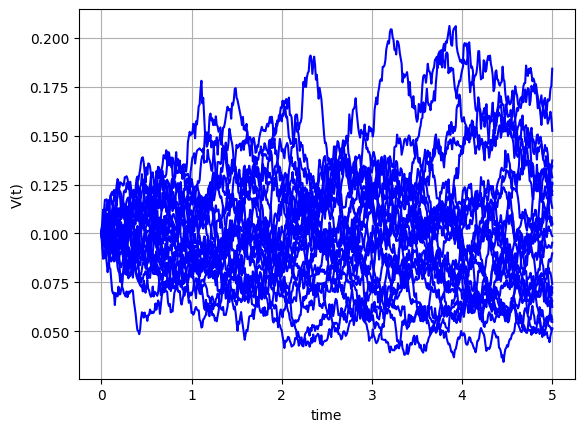

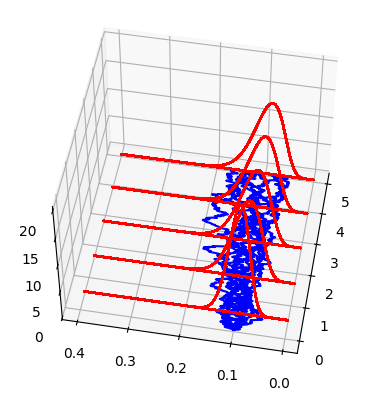

In [ ]:
#%%
"""
Created on Jan 20 2019
Paths for the CIR process
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate as integrate
from mpl_toolkits import mplot3d

def GeneratePathsCIREuler(NoOfPaths,NoOfSteps,T,kappa,v0,vbar,gamma):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):

        # Making sure that samples from a normal have mean 0 and variance 1

        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W[:,i+1]-W[:,i])

        # We apply here the truncated scheme for negative values
        # Below line makes sure that the process is non-negative and hence typically not Euler scheme
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        time[i+1] = time[i] +dt
        
    # Outputs

    paths = {"time":time,"V":V}
    return paths

def CIRDensity(kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    ncx2PDF = lambda x : 1.0/c * st.ncx2.pdf(x/c,delta,kappaBar)
    return ncx2PDF

# The mean of the CIR process is given by the following formula = c*(d + lambda)
def CIRMean(kappa,gamma,vbar,v0,T):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= lambda s,t: 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = lambda s,t,v_s: 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    return c(0,T)*(delta + kappaBar(0.0,T,v0))

def mainCalculation():
    NoOfPaths = 25
    NoOfSteps = 500
    T     = 5
    kappa =0.5
    v0    =0.1
    vbar  =0.1
    gamma =0.1    # Run after changing gamma to 0.35 and see the difference in the density
    
    Paths = GeneratePathsCIREuler(NoOfPaths,NoOfSteps,T,kappa,v0,vbar,gamma)
    timeGrid = Paths["time"]
    V = Paths["V"]
    
    plt.figure(1)
    plt.plot(timeGrid, np.transpose(V),'b')   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("V(t)")
       
    # 3D graph for X(t) for paths vs. density

    plt.figure(2)
    ax = plt.axes(projection='3d')
    zline = np.zeros([len(timeGrid),1])
    
    # Plot paths

    n = 10
    for i in range(0,n,1):
        y1 = np.squeeze(np.transpose(V[i,:]))
        x1 = timeGrid
        z1 = np.squeeze(zline)
        ax.plot3D(x1, y1, z1, 'blue')
    ax.view_init(50, -170)
    
    Ti = np.linspace(0.5,T,5)
    
    y1 = np.linspace(0.001,0.4,100)
    for ti in Ti:

        # Density for the V(t) process    

        ncx2PDF = CIRDensity(kappa,gamma,vbar,0.0,ti,v0)
        x1 = np.zeros([len(y1),1]) + ti
        z1 = ncx2PDF(y1) 
        ax.plot3D(x1, y1, z1, 'red')
        
    # Compute numerical expectation and compare to analytical expression

    EV_num = integrate.trapezoid(y1*ncx2PDF(y1) ,y1)
    print("numerical: E[V(t=5)]={0}".format(EV_num))
    print("theoretical: E[V(t=5)]={0}".format(CIRMean(kappa,gamma,vbar,v0,T)))
    
mainCalculation()